In [20]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [21]:
weather_set_dirty = pd.read_csv('CSV/Weather_LosAngeles.csv', sep=",")
weather_set_dirty['timestamp'] = pd.to_datetime(weather_set_dirty['timestamp'])

mean_values_by_day = weather_set_dirty.groupby(weather_set_dirty["timestamp"].dt.date).mean(numeric_only=True).round(1)

for col in mean_values_by_day.columns:
    weather_set_dirty[col] = weather_set_dirty.apply(
        lambda row: mean_values_by_day.loc[row['timestamp'].date(), col]
        if pd.isnull(row[col]) else row[col],
        axis=1
    )

weather_set_dirty['cloud_cover_description'].fillna(method='ffill',inplace=True)

weather_set_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77362 entries, 0 to 77361
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   city                     77362 non-null  object        
 1   timestamp                77362 non-null  datetime64[ns]
 2   temperature              77362 non-null  float64       
 3   cloud_cover              77362 non-null  float64       
 4   cloud_cover_description  77362 non-null  object        
 5   pressure                 77362 non-null  float64       
 6   windspeed                77362 non-null  float64       
 7   precipitation            77362 non-null  float64       
 8   felt_temperature         77362 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 5.3+ MB


In [22]:
bike_set_dirty = pd.read_csv('CSV/metro_2017_2022.csv', sep=',', index_col=0)

bike_set_dirty.sort_values('start_station_id')
bike_set_dirty['start_station_lat'].fillna(method="ffill", inplace=True)
bike_set_dirty['start_station_lon'].fillna(method="ffill", inplace=True)

bike_set_dirty.sort_values('end_station_id')
bike_set_dirty['end_station_lat'].fillna(method="ffill", inplace=True)
bike_set_dirty['end_station_lon'].fillna(method="ffill", inplace=True)

bike_set_dirty_agg_start = bike_set_dirty.groupby('start_station_id')[['start_station_lat', 'start_station_lon']].agg(lambda x: x.mode().iloc[0])
bike_set_dirty_agg_end = bike_set_dirty.groupby('end_station_id')[['end_station_lat', 'end_station_lon']].agg(lambda x: x.mode().iloc[0])

bike_set_dirty_merge = bike_set_dirty.merge(bike_set_dirty_agg_start, on='start_station_id', suffixes=('','_mode'))
bike_set_dirty_merged = bike_set_dirty_merge.merge(bike_set_dirty_agg_end, on='end_station_id', suffixes=('','_mode'))

dateformat0 = "%H/%M/%S %d-%m-%Y"
dateformat1 = "%Y-%m-%d %H:%M:%S"
for i, row in bike_set_dirty_merged.iterrows():
    bike_set_dirty_merged.at[i, 'start_station_lat'] = bike_set_dirty_merged.loc[i, 'start_station_lat_mode']
    bike_set_dirty_merged.at[i, 'start_station_lon'] = bike_set_dirty_merged.loc[i, 'start_station_lon_mode']
    bike_set_dirty_merged.at[i, 'end_station_lat'] = bike_set_dirty_merged.loc[i, 'end_station_lat_mode']
    bike_set_dirty_merged.at[i, 'end_station_lon'] = bike_set_dirty_merged.loc[i, 'end_station_lon_mode']

    try:
        bike_set_dirty_merged.at[i, 'start_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'start_time'], dateformat0)
    except ValueError:
        bike_set_dirty_merged.at[i, 'start_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'start_time'], dateformat1)
    try:
        bike_set_dirty_merged.at[i, 'end_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'end_time'], dateformat0)
    except ValueError:
        bike_set_dirty_merged.at[i, 'end_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'end_time'], dateformat1)

bike_set_almost_clean = bike_set_dirty_merged
bike_set_clean = bike_set_almost_clean.drop(['start_station_lat_mode', 'start_station_lon_mode', 'end_station_lat_mode', 'end_station_lon_mode'], axis=1)
bike_set_clean['start_time'] = pd.to_datetime(bike_set_almost_clean['start_time'], format="%Y-%m-%d %H:%M:%S")
bike_set_clean['end_time'] = pd.to_datetime(bike_set_almost_clean['end_time'], format="%Y-%m-%d %H:%M:%S")
bike_set_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 0 to 1552781
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   start_time         1552782 non-null  datetime64[ns]
 1   end_time           1552782 non-null  datetime64[ns]
 2   start_station_id   1552782 non-null  int64         
 3   start_station_lat  1552782 non-null  float64       
 4   start_station_lon  1552782 non-null  float64       
 5   end_station_id     1552782 non-null  int64         
 6   end_station_lat    1552782 non-null  float64       
 7   end_station_lon    1552782 non-null  float64       
 8   bike_id            1552782 non-null  object        
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 150.7+ MB


In [23]:
metro = bike_set_clean
metro['idle_time'] = None
metro = metro.sort_values(by='end_time')

BigDict = {
    # station_id: {
    #     transaction_id: end_time
    # }
}

for i, row in metro.iterrows():
    current_start_time = row["start_time"]
    current_end_time = row["end_time"]
    current_end_station_id = row["end_station_id"]
    current_start_station_id = row["start_station_id"]
    current_bike_id = row["bike_id"]
    current_transaction_id = i

    if current_start_station_id in BigDict:
        for transaction in list(BigDict[current_start_station_id]):  # Create a copy of the keys
            if current_start_time < BigDict[current_start_station_id][transaction]:
                continue
            if metro.at[transaction, "idle_time"] is not None:
                continue
            idle_time = current_start_time - BigDict[current_start_station_id][transaction]
            metro.at[transaction, "idle_time"] = idle_time
            #if idle_time.total_seconds() >= 0:
            del BigDict[current_start_station_id][transaction]

    if current_end_station_id not in BigDict:
        BigDict[current_end_station_id] = {current_transaction_id: current_end_time}

    BigDict[current_end_station_id][current_transaction_id] = current_end_time

metro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 690312 to 373108
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   start_time         1552782 non-null  datetime64[ns]
 1   end_time           1552782 non-null  datetime64[ns]
 2   start_station_id   1552782 non-null  int64         
 3   start_station_lat  1552782 non-null  float64       
 4   start_station_lon  1552782 non-null  float64       
 5   end_station_id     1552782 non-null  int64         
 6   end_station_lat    1552782 non-null  float64       
 7   end_station_lon    1552782 non-null  float64       
 8   bike_id            1552782 non-null  object        
 9   idle_time          1551807 non-null  object        
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 162.6+ MB


In [24]:
metro = metro.sort_values(by='start_time')
#Create the corresponding columns
metro["morgens"] = 0
metro["vormittags"] = 0
metro["mittags"] = 0
metro["nachmittags"]=0
metro["abends"]=0
metro["nachts"]=0

#set the start and end of each day time
morgens = range(5,9)
vormittags = range(9,12)
mittags = range(12,15)
nachmittags = range(15,19)
abends = range(19, 23)
nachts = [23,0,1,2,3,4]

#This list will serve as string provider that we can insert later, to access the proper column
TagesZeiten = ["morgens", "vormittags", "mittags", "nachmittags", "abends", "nachts"]
#This list will serve to provide the start time of each day time, so we know when to change columns
Intervall_starts = [5,9,12,15,19,23]

metro["monday"] = 0
metro["tuesday"] = 0
metro["wednesday"] = 0
metro["thursday"] = 0
metro["friday"] = 0
metro["saturday"] = 0
metro["sunday"] = 0

Days = ["monday","tuesday","wednesday", "thursday","friday","saturday", "sunday"]

#Make sure to change the "idle_time" to a timedelta object, so we can use .totalseconds() later
metro["idle_time"] = pd.to_timedelta(metro["idle_time"])

# Iterate through each row in the DataFrame
for i, row in metro.iterrows():
    end_date = row["end_time"] + row["idle_time"]
    #we only need the starting time hour
    end_hour = end_date.hour
    # and we need to know the duration (idle time) we need to look back
    idle_time = row["idle_time"]
    # make sure to skip any rows with no idle times, since they have 0s in the day times columns
    try:
        NumHours = float(idle_time.total_seconds() / 3600)
        if end_hour in morgens:
            index = 0
        elif end_hour in vormittags:
            index = 1
        elif end_hour in mittags:
            index = 2
        elif end_hour in nachmittags:
            index = 3
        elif end_hour in abends:
            index = 4
        elif end_hour in nachts:
            index = 5

        while NumHours >0 and index > -6:
            metro.at[i, TagesZeiten[index]] = 1
            DistanceToIntervallStart = abs(Intervall_starts[index]- end_hour)

            NumHours -= DistanceToIntervallStart
            end_hour -= DistanceToIntervallStart
            index -= 1

        NumDays = float(row["idle_time"].total_seconds() / (24 * 60 * 60))

        day = end_date.weekday()

        while NumDays > 0 and day > -7:
            metro.at[i, Days[day]] = 1

            NumDays -= 1
            day -= 1

    except ValueError:
        continue


In [25]:
weather_set = weather_set_dirty
metro_set = metro

In [26]:
weather_set.info(), metro_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77362 entries, 0 to 77361
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   city                     77362 non-null  object        
 1   timestamp                77362 non-null  datetime64[ns]
 2   temperature              77362 non-null  float64       
 3   cloud_cover              77362 non-null  float64       
 4   cloud_cover_description  77362 non-null  object        
 5   pressure                 77362 non-null  float64       
 6   windspeed                77362 non-null  float64       
 7   precipitation            77362 non-null  float64       
 8   felt_temperature         77362 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 690312 to 827163
Data columns (total 23 columns):
 #   Column             Non-Null 

(None, None)

In [27]:
metro_set.sort_values('start_time', inplace=True)
weather_set.sort_values('timestamp', inplace=True)

Weather_Set1 = weather_set.set_index('timestamp').reindex(metro_set.set_index('start_time').index, method='nearest')
Weather_Set1 = Weather_Set1.loc[~Weather_Set1.index.duplicated(keep='first')].reset_index()

merged_set = pd.merge(metro_set, Weather_Set1, on='start_time', how='left')
merged_set = merged_set.drop(['city'], axis=1)
merged_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 0 to 1552781
Data columns (total 30 columns):
 #   Column                   Non-Null Count    Dtype          
---  ------                   --------------    -----          
 0   start_time               1552782 non-null  datetime64[ns] 
 1   end_time                 1552782 non-null  datetime64[ns] 
 2   start_station_id         1552782 non-null  int64          
 3   start_station_lat        1552782 non-null  float64        
 4   start_station_lon        1552782 non-null  float64        
 5   end_station_id           1552782 non-null  int64          
 6   end_station_lat          1552782 non-null  float64        
 7   end_station_lon          1552782 non-null  float64        
 8   bike_id                  1552782 non-null  object         
 9   idle_time                1551807 non-null  timedelta64[ns]
 10  morgens                  1552782 non-null  int64          
 11  vormittags               1552782 non-null  int64  

In [28]:
merged_set_descriptive = merged_set
mean_idle_time = merged_set_descriptive.groupby("end_station_id")["idle_time"].mean()

count_morning = merged_set_descriptive.groupby("end_station_id")["morgens"].sum()
count_vormittag = merged_set_descriptive.groupby("end_station_id")["vormittags"].sum()
count_midday = merged_set_descriptive.groupby("end_station_id")["mittags"].sum()
count_afternoon = merged_set_descriptive.groupby("end_station_id")["nachmittags"].sum()
count_evening = merged_set_descriptive.groupby("end_station_id")["abends"].sum()
count_night = merged_set_descriptive.groupby("end_station_id")["nachts"].sum()
count_mondays = merged_set_descriptive.groupby("end_station_id")["monday"].sum()
count_tuesdays = merged_set_descriptive.groupby("end_station_id")["tuesday"].sum()
count_wednesdays = merged_set_descriptive.groupby("end_station_id")["wednesday"].sum()
count_thursdays = merged_set_descriptive.groupby("end_station_id")["thursday"].sum()
count_fridays = merged_set_descriptive.groupby("end_station_id")["friday"].sum()
count_saturdays = merged_set_descriptive.groupby("end_station_id")["saturday"].sum()
count_sundays = merged_set_descriptive.groupby("end_station_id")["sunday"].sum()
station_lat = merged_set_descriptive.groupby("end_station_id")["end_station_lat"].unique()
station_lon = merged_set_descriptive.groupby("end_station_id")["end_station_lon"].unique()

result = pd.concat([mean_idle_time, count_morning, count_vormittag, count_midday, count_afternoon, count_evening, count_night, count_mondays, count_tuesdays, count_wednesdays, count_thursdays, count_fridays, count_saturdays, count_sundays, station_lat, station_lon], axis=1)
station_ID_with_AvgIdleDaytimesDays_and_lonlat = result.dropna(subset=["idle_time"])
station_ID_with_AvgIdleDaytimesDays_and_lonlat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 3000 to 4638
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   idle_time        394 non-null    timedelta64[ns]
 1   morgens          394 non-null    int64          
 2   vormittags       394 non-null    int64          
 3   mittags          394 non-null    int64          
 4   nachmittags      394 non-null    int64          
 5   abends           394 non-null    int64          
 6   nachts           394 non-null    int64          
 7   monday           394 non-null    int64          
 8   tuesday          394 non-null    int64          
 9   wednesday        394 non-null    int64          
 10  thursday         394 non-null    int64          
 11  friday           394 non-null    int64          
 12  saturday         394 non-null    int64          
 13  sunday           394 non-null    int64          
 14  end_station_lat  394 n

In [29]:
#Visualisation

In [30]:
merged_set_pred = merged_set.dropna(subset=["idle_time"])
merged_set_pred['idle_time'] = merged_set_pred['idle_time'].dt.total_seconds()/3600
merged_set_pred['end_hour'] = merged_set_pred['end_time'].dt.hour

le = LabelEncoder()
merged_set_pred['cloud_cover_description'] = le.fit_transform(merged_set_pred['cloud_cover_description'])

C:\Users\yusuf\AppData\Local\Temp\ipykernel_45996\872097037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_set_pred['idle_time'] = merged_set_pred['idle_time'].dt.total_seconds()/3600
C:\Users\yusuf\AppData\Local\Temp\ipykernel_45996\872097037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_set_pred['end_hour'] = merged_set_pred['end_time'].dt.hour
C:\Users\yusuf\AppData\Local\Temp\ipykernel_45996\872097037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [32]:
# Define target variable
y = merged_set_pred['idle_time'].values

# Define features
X = merged_set_pred.drop(['start_time', 'end_time', 'bike_id', 'idle_time', 'start_station_id','start_station_lat','start_station_lon'], axis=1)

# Extract feature names
feature_names = X.columns.tolist()

# Perform train-validation-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.285, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)



In [33]:
# Define the parameter grid
param_grid = {
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [31, 62, 93],
    'n_estimators': [100, 200, 300]
}

# Create a LightGBM model
lgbm_model = lgb.LGBMRegressor()

# Create the grid search object
grid = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='r2')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 300, 'num_leaves': 62}
0.9247843930059483


In [34]:
# Define the parameter grid
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create a DecisionTreeRegressor model
decTree_model = DecisionTreeRegressor()

# Create the grid search object
grid = GridSearchCV(decTree_model, param_grid, cv=5, scoring='r2')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(grid.best_params_)
print(grid.best_score_)

C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, e

{'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.9265709040624814


In [37]:
# Define the base models
base_models = [
    ('decision_tree', DecisionTreeRegressor(max_depth=20, max_features='log2', min_samples_leaf=1, min_samples_split=2)),
    ('lgbm', LGBMRegressor(learning_rate=0.1, max_depth=30, n_estimators=300, num_leaves=62))
]

# Define the meta model
meta_model = Lasso()

final_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
final_model.fit(X_train, y_train)

StackingRegressor(estimators=[('decision_tree',
                               DecisionTreeRegressor(max_depth=20,
                                                     max_features='log2')),
                              ('lgbm',
                               LGBMRegressor(max_depth=30, n_estimators=300,
                                             num_leaves=62))],
                  final_estimator=Lasso())

Validation MSE: 1992.6320823376059
Validation MAE: 3.7246926711264523
Validation R2: 0.9266494869588533
Test MSE: 1981.1959761813341
Test MAE: 3.820941911231212
Test R2: 0.9235511872713293


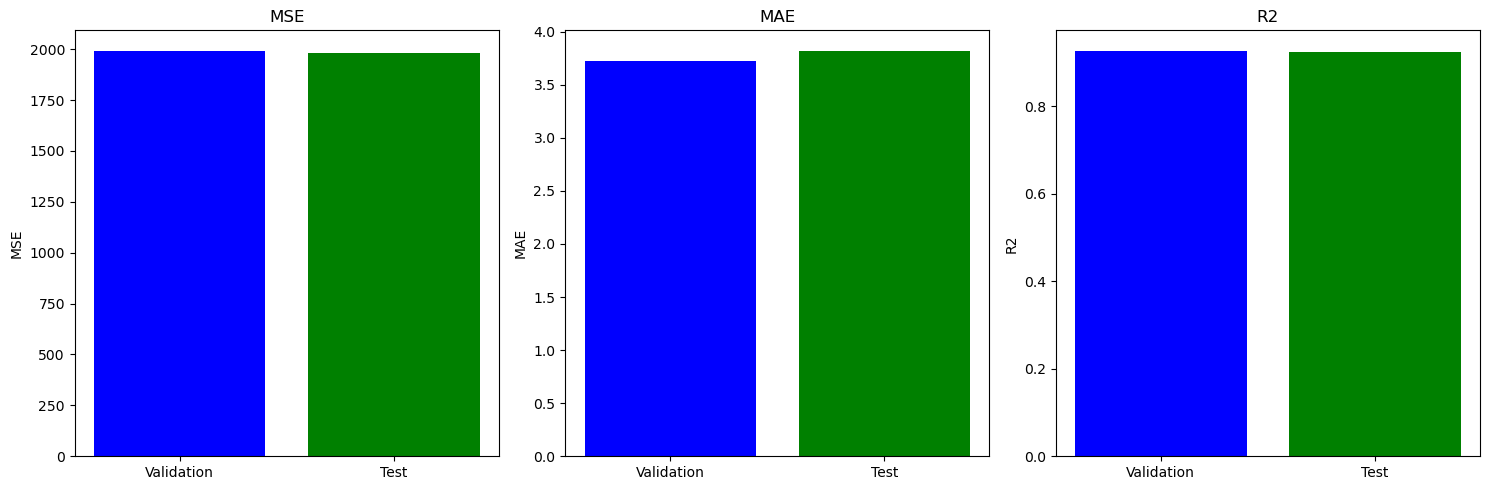

In [38]:
val_preds = final_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_mae = mean_absolute_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)

test_preds = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print('Validation MSE:', val_mse)
print('Validation MAE:', val_mae)
print('Validation R2:', val_r2)

print('Test MSE:', test_mse)
print('Test MAE:', test_mae)
print('Test R2:', test_r2)

labels = ['MSE', 'MAE', 'R2']
val_values = [val_mse, val_mae, val_r2]
test_values = [test_mse, test_mae, test_r2]

#Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# For each metric, create a bar plot comparing the validation and test values
for i in range(3):
    ax[i].bar(['Validation', 'Test'], [val_values[i], test_values[i]], color=['blue', 'green'])
    ax[i].set_title(labels[i])
    ax[i].set_ylabel(labels[i])

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()